No notebook anterior, nós aprendemos sobre o Perceptron. Vimos como ele aprende e como pode ser utilizado tanto para classificação binária quanto para regressão linear. Nesse notebook, nós veremos um algoritmo muito parecido com o Perceptron, mais conhecido como __Adaline__, que foi uma proposta de melhoria ao algoritmo original do Perceptron. Veremos as semelhanças e diferenças entre os dois algoritmos e iremos implementá-lo utilizando python e numpy. Por fim, vamos aplicar nos mesmos problemas de classificação do notebook do Perceptron para entender de fato suas diferenças. __O código para utilizar o Adaline em problemas de regressão é exatamente o mesmo do perceptron__.

__Objetivos__:

- Entender as diferenças entre os algoritmos do Perceptron e Adaline.
- Implementar o Adaline e seu modelo de aprendizado em Python puro e Numpy
- Utilizar o Adaline para classificação e regressão.

# Sumário

[Introdução](#Introdução)

[Regra de Aprendizado do Adaline](#Regra-de-Aprendizado-do-Adaline)

[Classificação](#Classificação)
- [Porta AND/OR](#Porta-AND/OR)
- [Exercício de Classificação](#Exerc%C3%ADcio-de-Classificação)

# Imports e Configurações

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

C:\Users\vinicius\Anaconda3\envs\mpdl\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Introdução

Poucos meses após a publicação do teorema da convergência do Perceptron por Rosenblatt, os engenheiros da Universidade de Stanford, Bernard Widrow e Marcian Hoff, publicaram um trabalho descrevendo uma rede neural muito parecida com o Perceptron, a __Adaline__ (do inglês _ADAptive LINear Element_). Porém, ao invés de utilizar a função _step_ como função de ativação, a __Adaline utiliza função de ativação linear e tem uma nova regra de aprendizado supervisionado__, conhecida como __regra de Widrow-Hoff__ (ou __regra delta__, ou ainda __regra LMS__). 

De fato, tanto o Perceptron quanto o Adaline possuem muitas características semelhantes e __é comum ver o pessoal confundindo o Perceptron com o Adaline__. Entre as principais semelhanças, podemos destacar:
- Ambos possuem __apenas um neurônio de N entradas e apenas uma saída. Não há camadas escondidas__.
- Ambos são __classificadores lineares binários__ por definição, mas podemos adaptá-los para efetuar __regressão linear__, da mesma forma como vimos no notebook sobre o Perceptron. __Na verdade, o código para treinar um Adaline para regressão é o mesmo de um Perceptron__.
- Ambos tem o **método de aprendizagem _online_**. Isto é, a atualização dos pesos é efetuada amostra por amostra.
- Ambos tem uma **função _step_ para classificação**. Porém, ao contrário do Perceptron, __na Adaline ela não é utilizada na atualização dos pesos__. Nós veremos por que a seguir.

Porém, a principal diferença entre o Perceptron e a Adaline é que o Perceptron utiliza os labels das classes para fazer a atualização dos pesos, enquanto __a Adaline utiliza o resultado da função de ativação (linear) como valor contínuo de predição__. Isto é, ao invés da saída ser discreta como no Perceptron (0 ou 1), __na Adaline a saída pode ser qualquer valor contínuo__. Essa diferença fica mais clara quando vemos a figura a seguir:

<img src="images/comparacao_perceptron_adaline.png">

[Fonte](https://www.quora.com/What-is-the-difference-between-a-Perceptron-Adaline-and-neural-network-model)

Repare, como dito, que ambos têm a função _step_. No Perceptron, ela é utilizada como função de ativação. No Adaline, por sua vez, a função de ativação é linear e a funcão _step_ é utilizada para gerar a predição. 

Por calcular a saída como um valor contínuo, __muitos consideram o Adaline mais poderoso__, uma vez que a diferença entre a saída desejada e o valor predito ($y_i - \widehat{y}_i$) nos diz agora "o quanto estamos certos ou errados". __Na prática, isso faz com o que o Adaline tente encontrar a "melhor solução" para o problema, ao invés de somente uma "solução adequada"__. Tomando como exemplo a figura abaixo, o Perceptron pode encontrar diversas retas que separam as classes, enquanto o Adaline tenta encontrar a melhor reta que separa as classes.

<img src="images/hiperplanos_perceptron_adaline.png" width='700'>

[Fonte](http://www.barbon.com.br/wp-content/uploads/2013/08/RNA_Aula4.pdf)

Ok, mas como isso muda o aprendizado? É o que veremos a seguir.

## Regra de Aprendizado do Adaline

A atualização dos pesos do Adaline é dada pela mesma fórmula do Perceptron:

$$w_i = w_i + \lambda(y_i - \widehat{y}_i)x_i$$

Onde $\lambda$ é a __taxa de aprendizagem__.

Mas você já imaginou da onde vem essa fórmula? Em primeiro lugar, o método de atualização dos pesos é baseado na __Regra Delta__ (*Delta Rule*). Sendo $\overrightarrow{w} = \{w_1, w_2, ..., w_D\}$, a atualização dos pesos é dada por:

$$\overrightarrow{w} = \overrightarrow{w} - \Delta{\overrightarrow{w}}$$

em que:

$$\Delta{\overrightarrow{w}} = \lambda\nabla E(\overrightarrow{w})$$

Sendo $\nabla E(\overrightarrow{w})$ o gradiente de uma função que depende de $\overrightarrow{w}$ e que queremos minimizar.

No caso do Adaline, __a função de custo é dada pela soma dos erros quadrados__:

$$J(w) = \frac{1}{2}\sum_{i}^N (y_i - \widehat{y}_i)^2$$

Onde $N$ é a quantidade de amostras nos dados, e as demais variáveis representam as mesmas vistas anteriormente. Repare que a função de custo é quase uma _Mean Squared Error (MSE)_, só que ao invés de dividir por $N$, estamos dividindo por 2 o resultado do somatório. O por quê disso será entendido mais a frente na demonstração.

Queremos encontrar, então, o vetor $\overrightarrow{w}$ que minimiza a função $J$. Assim, temos:

$$\frac{\partial J}{\partial w_i} = \frac{\partial}{\partial w_i}\frac{1}{2}\sum_i^N (y_i - \widehat{y}_i)^2$$

Como a derivada do somatório é igual ao somatório das derivadas:

$$= \frac{1}{2}\sum_i^N \frac{\partial}{\partial w_i}(y_i - \widehat{y}_i)^2$$

Aplicando a regra da cadeia:

$$= \sum_i^N (y_i - \widehat{y}_i)\frac{\partial}{\partial w_i}(y_i - \widehat{y}_i)$$

Repare que, quando derivamos $(y_i - \widehat{y}_i)^2$, o expoente 2, ao sair do somatório, foi multiplicado por $\frac{1}{2}$, tornando-o 1. Isso é o que os matemáticos denominam de "conveniência matemática". 

Como $\widehat{y}_i = x_iw_i + b$ é uma função que depende de $w$, e sua derivada em relação a $w_i$ é apenas $x_i$, temos que:

$$\frac{\partial J}{\partial w_i} = \sum_i^N (y_i - \widehat{y}_i)(-x_i)$$
$$\frac{\partial J}{\partial w_i} = -\sum_i^N (y_i - \widehat{y}_i)x_i$$

$$\frac{\partial J}{\partial \overrightarrow{w}} = -(\overrightarrow{y} - \overrightarrow{\widehat{y}})\overrightarrow{x}$$

De maneira análoga, podemos calcular que a derivada de $J$ em relação a $b_i$ é:

$$\frac{\partial J}{\partial b_i} = -\sum_i^N (y_i - \widehat{y}_i)\cdot 1$$

Já que a derivada de $\widehat{y}_i$ em relação a $b_i$ ($\frac{\partial \widehat{y}_i}{\partial b_i}$) é igual a 1. Logo, a atualização dos bias será dada por:

$$b_i = b_i + \lambda(y_i - \widehat{y}_i)$$

# Regressão

In [78]:
df = pd.read_csv('data/notas.csv')

print(df.shape)
df.head(10)

(25, 4)


,prova1,prova2,prova3,final
0,73,80,75,152
1,93,88,93,185
2,89,91,90,180
3,96,98,100,196
4,73,66,70,142
5,53,46,55,101
6,69,74,77,149
7,47,56,60,115
8,87,79,90,175
9,79,70,88,164


In [79]:
x = df[['prova1', 'prova2', 'prova3']].values
y = df['final'].values.reshape(-1, 1)

print(x.shape, y.shape)

(25, 3) (25, 1)


In [80]:
minmax = MinMaxScaler(feature_range=(-1,1))
x = minmax.fit_transform(x.astype(np.float64))

In [81]:
D = x.shape[1]
w = [2*random() - 1 for i in range(D)]
b = 2*random() - 1

learning_rate = 1e-2

for step in range(2001):
    cost = 0
    for x_n, y_n in zip(x, y):
        y_pred = sum([x_i*w_i for x_i, w_i in zip(x_n, w)]) + b
        error = y_n - y_pred
        w = [w_i + learning_rate*error*x_i for x_i, w_i in zip(x_n, w)]
        b = b + learning_rate*error
        cost += error**2
        
    if step%200 == 0:
        print('step {0}: {1}'.format(step, cost))

# print('w:', [np.round(w_i, 2)[0] for w_i in w])
print('w:', np.round(np.array(w).flatten(), 2))
print('b:', np.round(b, 2))

y_pred = np.dot(x, w) + b 
print('y_pred:', np.round(y_pred.flatten()))

step 0: [504732.77237875]
step 200: [173.61227519]
step 400: [148.41252172]
step 600: [146.40839514]
step 800: [146.18215443]
step 1000: [146.15439728]
step 1200: [146.15104547]
step 1400: [146.15068259]
step 1600: [146.1506596]
step 1800: [146.15066502]
step 2000: [146.15066871]
w: [ 8.73 14.14 26.32]
b: [150.71]
y_pred: [153. 185. 182. 200. 139. 104. 150. 113. 175. 165. 143. 142. 187. 152.
 151. 189. 144. 182. 177. 158. 177. 175. 168. 151. 191.]


# Classificação

## Porta AND/OR

In [82]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
# y = np.array([[0, 1, 1, 1]]).T # porta OR
y = np.array([0, 0, 0, 1]).T # porta AND

print(x.shape, y.shape)

(4, 2) (4,)


### Python

In [83]:
D = x.shape[1]
w = [2*random() - 1 for i in range(D)]
b = 2*random() - 1

learning_rate = 1e-1 # estimei 1e-2

for step in range(101):
    cost = 0
    for x_n, y_n in zip(x, y):
        # qual linha devemos remover para transformar o Perceptron num Adaline?
        y_pred = sum([x_i*w_i for x_i, w_i in zip(x_n, w)]) + b
#         y_pred = 1 if y_pred > 0 else 0
        error = y_n - y_pred
        w = [w_i + learning_rate*error*x_i for x_i, w_i in zip(x_n, w)]
        b = b + learning_rate*error
        cost += error**2
        
    if step%10 == 0:
        print('step {0}: {1}'.format(step, cost))

# print('w:', [np.round(w_i, 2) for w_i in w])
print('w:', np.round(np.array(w), 2))
print('b:', np.round(b, 2))

y_pred = np.dot(x, w) + b 
y_pred_class = np.where(y_pred > 0, 1, 0)

print('y_pred:', np.round(y_pred, 2))
print('y_pred_class:', y_pred_class)

step 0: 0.9576678566966844
step 10: 0.32370086049213925
step 20: 0.3112714227196156
step 30: 0.30902756352520466
step 40: 0.30862439314370643
step 50: 0.3085791712232067
step 60: 0.3085955815681847
step 70: 0.3086143914835381
step 80: 0.30862684116572325
step 90: 0.3086339784416463
step 100: 0.3086378320647464
w: [0.56 0.53]
b: -0.28
y_pred: [-0.28  0.25  0.28  0.81]
y_pred_class: [0 1 1 1]


### Numpy

In [84]:
D = x.shape[1]
w = 2*np.random.random(size=D)-1
b = 2*np.random.random()-1       

learning_rate = 1e-1 # <- use a mesma learning rate do python

for step in range(101):
    cost = 0
    for x_n, y_n in zip(x, y):
        # qual linha devemos remover para transformar o Perceptron num Adaline?
        y_pred = np.dot(x_n, w) + b 
#         y_pred = np.where(y_pred > 0, 1, 0)
        error = y_n - y_pred
        w = w + learning_rate*np.dot(error, x_n)
        b = b + learning_rate*error
        cost += error**2
    
    if step%10 == 0:
        print('step {0}: {1}'.format(step, cost))
    

print('w:', np.round(w, 2))
print('b:', np.round(b, 2))

# print(f'w: {w:.2f}')
# print(f'b: {b:.2f}')

y_pred = np.dot(x, w) + b 
y_pred_class = np.where(y_pred > 0, 1, 0)

# print('y_pred: {0}'.format(y_pred))
print('y_pred:', np.round(y_pred, 2))
print('y_pred_class: {0}'.format(y_pred_class))

step 0: 2.5755430382119964
step 10: 0.7629801827380189
step 20: 0.4175429612497956
step 30: 0.3339073132065329
step 40: 0.31394761859918763
step 50: 0.30944163751439924
step 60: 0.3085713750750845
step 70: 0.3084868026750751
step 80: 0.30853362534333184
step 90: 0.3085797867072916
step 100: 0.3086087306934916
w: [0.55 0.53]
b: -0.28
y_pred: [-0.28  0.25  0.28  0.81]
y_pred_class: [0 1 1 1]


## Exercício de Classificação

(100, 2) (100,)


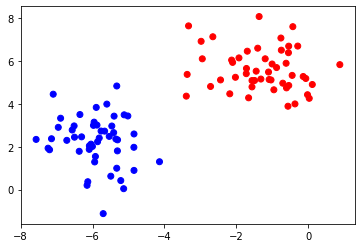

In [85]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=y.ravel(), cmap='bwr')

In [86]:
def plot_linear_classifier(x, y, w, b):
    x1_min, x1_max = x[:,0].min(), x[:,0].max()
    x2_min, x2_max = x[:,1].min(), x[:,1].max()

    x1, x2 = np.meshgrid(np.linspace(x1_min-1, x1_max+1,100), np.linspace(x2_min-1, x2_max+1, 100))
    x_mesh = np.array([x1.ravel(), x2.ravel()]).T

    plt.scatter(x[:,0], x[:,1], c=y.ravel(), cmap='bwr')

    y_mesh = np.dot(x_mesh, np.array(w).reshape(1, -1).T) + b
    y_mesh = np.where(y_mesh < 0.5, 0, 1)

    plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap='bwr', alpha=0.5)
    plt.xlim(x1_min-1, x1_max+1)
    plt.ylim(x2_min-1, x2_max+1)

### Python

step 0: 62.337180345303075
step 100: 2.312796397884707
step 200: 2.2071475247842978
step 300: 2.157707099796004
step 400: 2.134604900238757
step 500: 2.123833500299964
step 600: 2.1188276126878143
step 700: 2.116512412268276
step 800: 2.1154494152670344
step 900: 2.114966758715209
step 1000: 2.114751394660247
w: [0.14 0.08]
b: 0.69
y_pred: [ 0.88  0.25 -0.01  1.13  0.96  0.08  0.94  0.24  0.96  0.92  0.21  0.64
 -0.13  0.13 -0.   -0.07  1.05  1.12  0.1   0.87 -0.18  0.9   1.04  0.92
  0.08  0.91  0.04  1.07  0.86  0.98  0.74  0.85 -0.04 -0.02 -0.08  0.82
  1.    0.79  0.21  0.1  -0.18  0.02  0.    1.01 -0.03  1.    0.75  0.89
  0.12  1.18  0.97 -0.04 -0.15  0.21 -0.02  1.14  1.09  1.23  0.98  1.01
  1.1   0.32  0.69  0.87  0.56 -0.03 -0.01  0.92 -0.01  1.02 -0.05  0.12
  1.14 -0.02  0.09  0.82  0.08  0.75  0.07  1.1  -0.2   0.16  0.06  0.2
  1.28  0.15  1.09  0.1   0.88  0.95  0.81 -0.2  -0.06  0.    0.04 -0.16
  0.87  1.03  0.1   0.16]
y_pred_class: [1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 

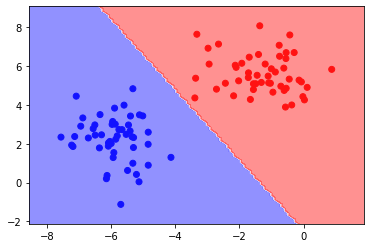

In [87]:
D = x.shape[1]
w = [2*random() - 1 for i in range(D)]
b = 2*random() - 1

learning_rate = 1e-3 # mesmas estimativas
for step in range(1001): # <- tente estimar a #epochs
    cost = 0
    for x_n, y_n in zip(x, y):
        y_pred = sum([x_i*w_i for x_i, w_i in zip(x_n, w)]) + b
        error = y_n - y_pred
        w = [w_i + learning_rate*error*x_i for x_i, w_i in zip(x_n, w)]
        b = b + learning_rate*error
        cost += error**2
        
    if step%100 == 0:
        print('step {0}: {1}'.format(step, cost))

print('w:', np.round(np.array(w), 2))
print('b:', np.round(b, 2))

y_pred = np.dot(x, w) + b 
y_pred_class = np.where(y_pred > 0, 1, 0)

print('y_pred:', np.round(y_pred, 2))
print('y_pred_class:', y_pred_class)

plot_linear_classifier(x, y, w, b)

### Numpy

step 0: 34.21053370329995
step 100: 2.6135960074823217
step 200: 2.6126007132129065
step 300: 2.6126343291071774
step 400: 2.6126350093060493
step 500: 2.6126350226631625
step 600: 2.612635022925305
step 700: 2.612635022930449
step 800: 2.6126350229305513
step 900: 2.612635022930553
step 1000: 2.612635022930553
w: [0.15 0.07]
b: 0.71
y_pred: [ 0.81  0.18 -0.06  1.07  0.91  0.03  0.91  0.17  0.94  0.9   0.15  0.57
 -0.22  0.07 -0.07 -0.14  1.02  1.08  0.02  0.81 -0.26  0.85  1.02  0.89
  0.    0.87 -0.03  1.03  0.81  0.95  0.69  0.81 -0.09 -0.1  -0.16  0.74
  0.96  0.76  0.13  0.03 -0.26 -0.04 -0.07  0.97 -0.09  0.97  0.7   0.85
  0.06  1.14  0.93 -0.12 -0.21  0.17 -0.11  1.1   1.06  1.18  0.95  0.96
  1.07  0.23  0.63  0.83  0.5  -0.08 -0.08  0.88 -0.08  0.98 -0.11  0.06
  1.09 -0.09  0.02  0.77  0.02  0.69 -0.02  1.05 -0.29  0.1  -0.01  0.12
  1.26  0.08  1.07  0.04  0.84  0.91  0.74 -0.24 -0.15 -0.08 -0.06 -0.22
  0.83  1.01  0.02  0.08]
y_pred_class: [1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0

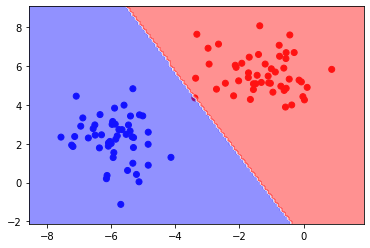

In [88]:
D = x.shape[1]
w = 2*np.random.random(size=D)-1
b = 2*np.random.random()-1       

learning_rate = 1e-2 # <- use a mesma learning rate do python

for step in range(1001): # <- use a mesma #epochs do python
    cost = 0
    for x_n, y_n in zip(x, y):
        y_pred = np.dot(x_n, w) + b 
        error = y_n - y_pred
        w = w + learning_rate*np.dot(error, x_n)
        b = b + learning_rate*error
        cost += error**2
    
    if step%100 == 0:
        print('step {0}: {1}'.format(step, cost))
    
print('w:', np.round(w, 2))
print('b:', np.round(b, 2))

y_pred = np.dot(x, w) + b 
y_pred_class = np.where(y_pred > 0, 1, 0)

print('y_pred:', np.round(y_pred, 2))
print('y_pred_class:', y_pred_class)

plot_linear_classifier(x, y, w, b)

# Referências

- [http://sisne.org/Disciplinas/PosGrad/PsicoConex/aula6.pdf](http://sisne.org/Disciplinas/PosGrad/PsicoConex/aula6.pdf)
- [What is the difference between a Perceptron, Adaline, and neural network model?](https://www.quora.com/What-is-the-difference-between-a-Perceptron-Adaline-and-neural-network-model)
- [RNA – Adaline e Regra do Delta](http://www.barbon.com.br/wp-content/uploads/2013/08/RNA_Aula4.pdf)